# Imports

In [1]:
from __future__ import print_function
print("... print_function imported")

import argparse
print("... argparse imported")
import gzip
print("... gzip imported")
import json
print("... json imported")
import os
print("... os imported")
import pickle
print("... pickle imported")

import numpy as np
print("... numpy imported")
import tensorflow as tf
print("... tensorflow imported")
import matplotlib.pyplot as plt
print("... matplotlib imported")

... print_function imported
... argparse imported
... gzip imported
... json imported
... os imported
... pickle imported
... numpy imported
... tensorflow imported
... matplotlib imported


# One-hot encoding

In [0]:
def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

# Download MNIST and split the data


In [0]:
def mnist(datasets_dir = './data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 28, 28, 1)
    test_y = test_y.astype('int32')

    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 28, 28, 1)
    valid_y = valid_y.astype('int32')

    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 28, 28, 1)
    train_y = train_y.astype('int32')

    print('... done loading data')
    return train_x, one_hot(train_y), valid_x, one_hot(valid_y), test_x, one_hot(test_y)

# LeNet

Our CNN consists of two convolutional layers (16 3x3 filters and a stride of 1), each followed by ReLU activation function and a max pooling layer (pool size 2). After the convolution layers we add a fully connected layer with 128 units and a softmax layer for the classification.

According to helpful link:
https://www.tensorflow.org/tutorials/estimators/cnn

In [0]:
def LeNet(x, num_filters, filter_size):

    pool_size = [2, 2]
    strides = 2

    # #1 Convolutional layer
    conv1 = tf.layers.conv2d(
        inputs = x,
        filters = num_filters,
        kernel_size = [filter_size, filter_size],
        padding = "same",
        activation = tf.nn.relu)

    # #1 Pooling layer
    pool1 = tf.layers.max_pooling2d(
        inputs = conv1,
        pool_size = pool_size,
        strides = strides)

    # #2 Convolutional layer
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = num_filters,
        kernel_size = [filter_size, filter_size],
        padding = "same",
        activation = tf.nn.relu)

    # #2 Pooling layer
    pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size = pool_size,
        strides = strides)

    # Flatten it!
    pool_flat = tf.contrib.layers.flatten(
        pool2,
        outputs_collections = None,
        scope = None)
    
    # Dense layer
    dense = tf.layers.dense(
        inputs = pool_flat,
        units = 1024,
        activation = tf.nn.relu)

    # Logits layer
    y_pred = tf.layers.dense(
        inputs = dense,
        units = 10)
    
    return y_pred

# Train and validate function

According to helpful link:
https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/r0.7/tensorflow/g3doc/tutorials/mnist/pros/index.md
    
"Here x and y_ aren‘t specific values. Rather, they are each a placeholder -- a value that we’ll input when we ask TensorFlow to run a computation. The input images x will consist of a 2d tensor of floating point numbers. 
Here we assign it a shape of [None, 784], where 784 is the dimensionality of a single flattened MNIST image, and None indicates that the first dimension, corresponding to the batch size, can be of any size. The target output classes
y_ will also consist of a 2d tensor, where each row is a one-hot 10-dimensional vector indicating which digit class the corresponding MNIST image belongs to."

returns learning_curve, model, validation_accuracy 

In [0]:
def train_and_validate(x_train, y_train, x_valid, y_valid, num_epochs, lr, num_filters, batch_size, filter_size, random_search = False):

    print()
    count = 0
    
    x_image = tf.placeholder(tf.float32, [None, 28, 28, 1], name = 'input')
    y_ = tf.placeholder(tf.float32, [None, 10], name = 'output')
        
    # Train and validate your convolutional neural networks with the provided data and hyperparameters
    num_samples = x_train.shape[0]
    num_batches = num_samples // batch_size

    y_pred = LeNet(x_image, num_filters, filter_size)
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = y_pred)
    cross_entropy = 100 * tf.reduce_mean(cross_entropy)
    
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_, 1))
    
    if (random_search == False):
      saver = tf.train.Saver()
    
    with tf.Session() as session:
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "accuracy")
      session.run(tf.global_variables_initializer())
      
      learning_curve  = np.zeros(num_epochs)   

      for i in range(num_epochs):
        for j in range(num_batches):

          x_batch = x_train[j * batch_size:(j + 1) * batch_size]
          y_batch = y_train[j * batch_size:(j + 1) * batch_size]

          train_step.run(feed_dict = {x_image: x_batch, y_: y_batch})

       # train_accuracy = accuracy.eval(feed_dict = {x_image: x_train, y_: y_train})
        learning_curve[i] = 1 - accuracy.eval(feed_dict = {x_image: x_valid, y_: y_valid})        
        validation_accuracy = accuracy.eval(feed_dict = {x_image: x_valid, y_: y_valid})
        print("step %d: validation accuracy %.4g%%" %(i, 100 * validation_accuracy))

      
      if (random_search == False):
        model = saver.save(session, './model/'+ str(count) +'.ckpt')
        count += 1
        print("Model saved in: %s" % model)
      else:
        model = None
    print()
    # Return the validation error after each epoch (i.e learning curve) and model
    return learning_curve, model, validation_accuracy 

# Test function

returns test error

In [0]:
def test(x_test, y_test, model):
  
    # test your network here by evaluating it on the test data
      tf.reset_default_graph()
      graph = tf.get_default_graph()   
      
      with tf.Session(graph = graph) as session:
      
        saver = tf.train.import_meta_graph(model + '.meta')
        saver.restore(session, model)
      
        accuracy = graph.get_tensor_by_name("accuracy:0")
        x_image = graph.get_tensor_by_name("input:0")
        y_ = graph.get_tensor_by_name("output:0")
        test_error = 1 - accuracy.eval(feed_dict = {x_image: x_test, y_: y_test})
         
      return test_error

# Save results

returns results, serialized 

In [0]:
def save_results(lr, num_filters, batch_size, filter_size, learning_curve, test_error, validation_accuracy):

  # save results in a dictionary
  results = dict()
  results["lr"] = lr
  results["num_filters"] = num_filters
  results["batch_size"] = batch_size
  results["filter_size"] = filter_size
  results["learning_curve"] = learning_curve
  results["test_error"] = test_error
    
  return results

# Vanilla version

default parameters, traininig, testing & plotting


In [0]:
lr = 1e-3
num_filters = 16
batch_size = 128
epochs = 12
filter_size = 3

In [9]:
x_train, y_train, x_valid, y_valid, x_test, y_test = mnist()    

... loading data
... done loading data


In [10]:
# train and test convolutional neural network

print("... starting training")
learning_curve, model, validation_accuracy = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr, num_filters, batch_size, filter_size)
print("... training and validation finished")
test_error = test(x_test, y_test, model)
print("... testing finished")

results = save_results(lr, num_filters, batch_size, filter_size, learning_curve, test_error, validation_accuracy)
print ("... checking results")
print(results)


... starting training

step 0: validation accuracy 87.85%
step 1: validation accuracy 93.08%
step 2: validation accuracy 95.08%
step 3: validation accuracy 96.04%
step 4: validation accuracy 96.57%
step 5: validation accuracy 97%
step 6: validation accuracy 97.17%
step 7: validation accuracy 97.24%
step 8: validation accuracy 97.39%
step 9: validation accuracy 97.5%
step 10: validation accuracy 97.65%
step 11: validation accuracy 97.75%
Model saved in: ./model/0.ckpt

... training and validation finished
INFO:tensorflow:Restoring parameters from ./model/0.ckpt
... testing finished
... checking results
{'lr': 0.001, 'num_filters': 16, 'batch_size': 128, 'filter_size': 3, 'learning_curve': array([0.12150002, 0.06919998, 0.0492    , 0.03960001, 0.03430003,
       0.02999997, 0.02829999, 0.02759999, 0.02609998, 0.02499998,
       0.02350003, 0.02249998]), 'test_error': 0.023299992084503174}


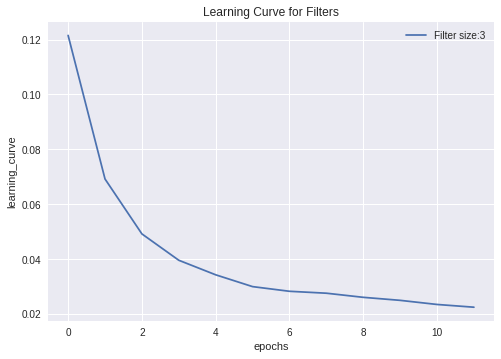

In [11]:
plt.plot(range(epochs), learning_curve, label = "Filter size:" + str(filter_size))
plt.xlabel('epochs')
plt.ylabel('learning_curve')
plt.title("Learning Curve for Filters")
plt.legend(loc='best')

plt.show()


# Impact of learning rate

In [12]:
lrs = [0.1, 0.01, 0.001, 0.0001]
learning_curve = list()

for i in range(len(lrs)):

    temp, model, validation_accuracy = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lrs[i], num_filters, batch_size, filter_size)  
    learning_curve.append(temp)

    test_error = test(x_test, y_test, model)
    
    results = save_results(lrs[i], num_filters, batch_size, filter_size, learning_curve[i], test_error.tolist(), validation_accuracy)
    print("---learning rate == ", lrs[i], "---")
    print(results)


step 0: validation accuracy 10.64%
step 1: validation accuracy 10.3%
step 2: validation accuracy 10.3%
step 3: validation accuracy 10.64%
step 4: validation accuracy 10.64%
step 5: validation accuracy 10.64%
step 6: validation accuracy 10.64%
step 7: validation accuracy 10.64%
step 8: validation accuracy 10.64%
step 9: validation accuracy 10.64%
step 10: validation accuracy 10.64%
step 11: validation accuracy 10.64%
Model saved in: ./model/0.ckpt

INFO:tensorflow:Restoring parameters from ./model/0.ckpt
---learning rate ==  0.1 ---
{'lr': 0.1, 'num_filters': 16, 'batch_size': 128, 'filter_size': 3, 'learning_curve': array([0.8936, 0.897 , 0.897 , 0.8936, 0.8936, 0.8936, 0.8936, 0.8936,
       0.8936, 0.8936, 0.8936, 0.8936]), 'test_error': 0.9218000024557114}

step 0: validation accuracy 97.18%
step 1: validation accuracy 97.91%
step 2: validation accuracy 98.33%
step 3: validation accuracy 98.56%
step 4: validation accuracy 98.69%
step 5: validation accuracy 98.83%
step 6: validation

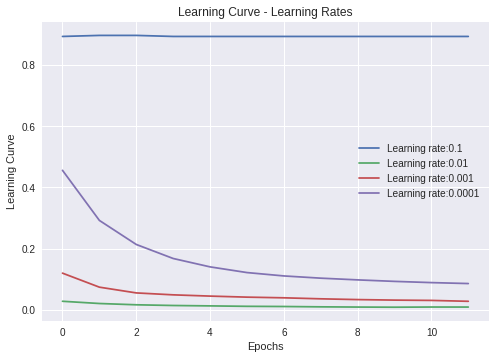

In [13]:
for i in range(len(lrs)):
    learning_rate = lrs[i]
    plt.plot(range(epochs), learning_curve[i], label = "Learning rate:" + str(learning_rate))
    plt.xlabel('Epochs')
    plt.ylabel('Learning Curve')
    plt.title("Learning Curve - Learning Rates")
    plt.legend(loc = 'best')

plt.show()

# Impact of number of filters

In [14]:
filters = [1, 3, 5, 7]
learning_curve = list()

for i in range(len(filters)):

    temp, model, validation_accuracy = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr, num_filters, batch_size, filters[i])
    learning_curve.append(temp)
      
    test_error = test(x_test, y_test, model)

    results = save_results(lr, filters[i], batch_size, filter_size, learning_curve[i], test_error.tolist(), validation_accuracy)
    print("---filters == ", filters[i], "---")
    print(results)


step 0: validation accuracy 80.14%
step 1: validation accuracy 83.4%
step 2: validation accuracy 84.86%
step 3: validation accuracy 86.06%
step 4: validation accuracy 87.09%
step 5: validation accuracy 88.01%
step 6: validation accuracy 88.58%
step 7: validation accuracy 88.89%
step 8: validation accuracy 89.17%
step 9: validation accuracy 89.47%
step 10: validation accuracy 89.79%
step 11: validation accuracy 90.06%
Model saved in: ./model/0.ckpt

INFO:tensorflow:Restoring parameters from ./model/0.ckpt
---filters ==  1 ---
{'lr': 0.001, 'num_filters': 1, 'batch_size': 128, 'filter_size': 3, 'learning_curve': array([0.19859999, 0.16600001, 0.15140003, 0.13940001, 0.12910002,
       0.11989999, 0.1142    , 0.11110002, 0.10829997, 0.10530001,
       0.10210001, 0.09939998]), 'test_error': 0.9143000021576881}

step 0: validation accuracy 86.46%
step 1: validation accuracy 91.87%
step 2: validation accuracy 94.09%
step 3: validation accuracy 95.12%
step 4: validation accuracy 95.7%
step 

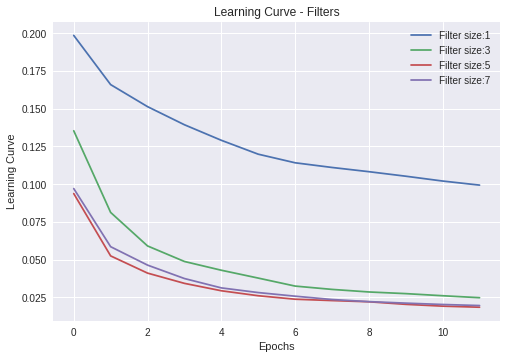

In [15]:
for i in range(len(filters)):
    filter_size = filters[i]
    plt.plot(range(epochs), learning_curve[i], label = "Filter size:" + str(filter_size))
    plt.xlabel('Epochs')
    plt.ylabel('Learning Curve')
    plt.title("Learning Curve - Filters")
    plt.legend(loc = 'best')

plt.show()

# Imports for random search

In [16]:
!pip install hpbandster

In [17]:
import logging
logging.basicConfig(level = logging.WARNING)

import hpbandster.core.nameserver as hpns
from hpbandster.optimizers import RandomSearch
from hpbandster.core.worker import Worker
import hpbandster.visualization as hpvis

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Random search

... loading data
... done loading data

step 0: validation accuracy 91.75%
step 1: validation accuracy 95.14%
step 2: validation accuracy 96.2%
step 3: validation accuracy 96.8%
step 4: validation accuracy 97.23%
step 5: validation accuracy 97.48%



step 0: validation accuracy 89.87%
step 1: validation accuracy 94.63%
step 2: validation accuracy 95.88%
step 3: validation accuracy 96.54%
step 4: validation accuracy 97.01%
step 5: validation accuracy 97.37%



step 0: validation accuracy 90.85%
step 1: validation accuracy 94.63%
step 2: validation accuracy 96%
step 3: validation accuracy 96.77%
step 4: validation accuracy 97.08%
step 5: validation accuracy 97.35%



step 0: validation accuracy 89.5%
step 1: validation accuracy 93.89%
step 2: validation accuracy 95.51%
step 3: validation accuracy 96.42%
step 4: validation accuracy 96.91%
step 5: validation accuracy 97.39%



step 0: validation accuracy 90.96%
step 1: validation accuracy 94.62%
step 2: validation accuracy 95.76%
step 3: v

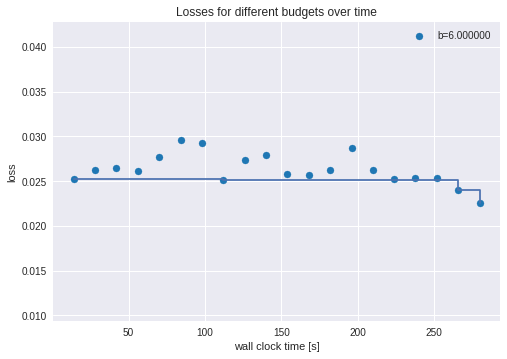

In [18]:
class MyWorker(Worker):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x_train, self.y_train, self.x_valid, self.y_valid, self.x_test, self.y_test = mnist("./")

    def compute(self, config, budget, **kwargs):
        """
        Evaluates the configuration on the defined budget and returns the validation performance.
        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train
        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """

        epochs = budget
        
        # train and validate your convolutional neural networks here
        learning_curve, model, validation_accuracy = train_and_validate(x_train, y_train,
                                                                     x_valid, y_valid,
                                                                     epochs, 
                                                                     lr,
                                                                     num_filters,
                                                                     batch_size,
                                                                     filter_size,
                                                                     random_search = True)
        print()
        # We minimize so make sure you return the validation error here
        return ({
            'loss': 1 - validation_accuracy,  # this is the a mandatory field to run hyperband
            'info': {}  # can be used for any user-defined information - also mandatory
        })

    @staticmethod
    def get_configspace():
        config_space = CS.ConfigurationSpace()

        # Implement configuration space here. See https://github.com/automl/HpBandSter/blob/master/hpbandster/examples/example_5_keras_worker.py  for an example
        lr = CSH.UniformFloatHyperparameter('learning_rate', lower = 1e-4, upper = 1e-1, default_value = '1e-2', log = True)
        batch_size = CSH.UniformIntegerHyperparameter('batch_size', lower = 16, upper = 128, default_value = 64, log = True)
        num_filters = CSH.UniformIntegerHyperparameter('num_filters', lower = 8, upper = 64, default_value = 16, log = True)        
        filter_size = CSH.CategoricalHyperparameter('filter_size', [3, 5])
        config_space.add_hyperparameters([lr, batch_size, num_filters, filter_size])

        return config_space

      
budget = 6
n_iterations = 20

# Step 1: Start a nameserver
# Every run needs a nameserver. It could be a 'static' server with a
# permanent address, but here it will be started for the local machine with the default port.
# The nameserver manages the concurrent running workers across all possible threads or clusternodes.
# Note the run_id argument. This uniquely identifies a run of any HpBandSter optimizer.
NS = hpns.NameServer(run_id = 'example1', host = '127.0.0.1', port = None)
NS.start()

# Step 2: Start a worker
# Now we can instantiate a worker, providing the mandatory information
# Besides the sleep_interval, we need to define the nameserver information and
# the same run_id as above. After that, we can start the worker in the background,
# where it will wait for incoming configurations to evaluate.
w = MyWorker(nameserver = '127.0.0.1', run_id = 'example1')
w.run(background = True)

# Step 3: Run an optimizer
# Now we can create an optimizer object and start the run.
# Here, we run RandomSearch, but that is not essential.
# The run method will return the `Result` that contains all runs performed.

rs = RandomSearch(configspace = w.get_configspace(),
                  run_id = 'example1', nameserver = '127.0.0.1',
                  min_budget = int(budget), max_budget = int(budget))
res = rs.run(n_iterations = n_iterations)

# Step 4: Shutdown
# After the optimizer run, we must shutdown the master and the nameserver.
rs.shutdown(shutdown_workers = True)
NS.shutdown()

# Step 5: Analysis
# Each optimizer returns a hpbandster.core.result.Result object.
# It holds information about the optimization run like the incumbent (=best) configuration.
# For further details about the Result object, see its documentation.
# Here we simply print out the best config and some statistics about the performed runs.

id2config = res.get_id2config_mapping()
incumbent = res.get_incumbent_id()

print('Best found configuration:', id2config[incumbent]['config'])

# Plots the performance of the best found validation error over time
all_runs = res.get_all_runs()
# Let's plot the observed losses grouped by budget,
import hpbandster.visualization as hpvis

hpvis.losses_over_time(all_runs)

plt.savefig("random_search.png")

# Best configuration

In [0]:
best_configuration = id2config[incumbent]['config']

batch_size = best_configuration['batch_size']
filter_size = best_configuration['filter_size']
learning_rate = best_configuration['learning_rate']
num_filters = best_configuration['num_filters']

In [20]:
# retrain the best configuration (called incumbent) and compute the test error

learning_curve, model, validation_accuracy = train_and_validate(x_train, y_train,
                                                                     x_valid, y_valid,
                                                                     epochs, 
                                                                     lr,
                                                                     num_filters,
                                                                     batch_size,
                                                                     filter_size)


step 0: validation accuracy 91.83%
step 1: validation accuracy 94.88%
step 2: validation accuracy 95.9%
step 3: validation accuracy 96.58%
step 4: validation accuracy 96.98%
step 5: validation accuracy 97.3%
step 6: validation accuracy 97.5%
step 7: validation accuracy 97.56%
step 8: validation accuracy 97.7%
step 9: validation accuracy 97.79%
step 10: validation accuracy 97.93%
step 11: validation accuracy 97.98%
Model saved in: ./model/0.ckpt



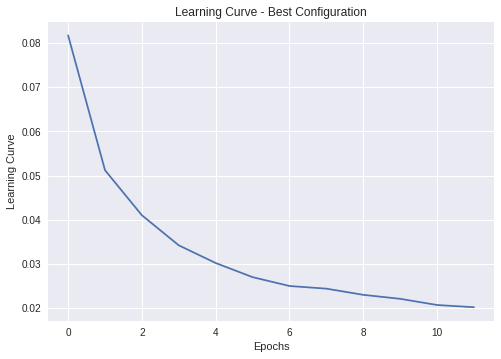

In [21]:
plt.plot(range(epochs), learning_curve)
plt.xlabel('Epochs')
plt.ylabel('Learning Curve')
plt.title("Learning Curve - Best Configuration")
plt.show()